In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import gc
import copy

from unet import *

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
class segmentation_dataset(Dataset):
    
    def __init__(self, image_paths, mask_paths, transform=None, mask_transform=None, in_memory=True):  
        
        assert(len(image_paths) == len(mask_paths))
        
        self.transform = transform
        self.mask_transform = mask_transform
        self.len = len(image_paths)
        self.in_memory = in_memory
        
        if not self.in_memory:
            self.image_paths = image_paths
            self.mask_paths = mask_paths
            return
        
        self.image = []
        self.mask = []

        for image_path, mask_path in tqdm(zip(image_paths, mask_paths)):
            
            image = io.imread(image_path)
            mask = io.imread(mask_path)
            
            if (len(image.shape)!=3):
                continue
            
            if self.transform is not None:
                image = self.transform(image)
            self.image.append(image)
            
            if self.mask_transform is not None:
                mask = self.mask_transform(np.expand_dims(mask,axis=-1))
            self.mask.append(mask)
            
        self.len = len(self.image)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        if self.in_memory:
            return self.image[idx], self.mask[idx]
        else:
            image_path = self.image_paths[idx]
            mask_path = self.mask_paths[idx]
            image = io.imread(image_path)
            mask = io.imread(mask_path)
            if self.transform is not None:
                image = self.transform(image)
            if self.mask_transform is not None:
                mask = self.mask_transform(np.expand_dims(mask,axis=-1))
            return image, mask

In [3]:
image_paths = sorted(glob.glob("segmentation/image64/*.jpg"))
mask_paths = sorted(glob.glob("segmentation/mask64/*.jpg"))
dataset = segmentation_dataset(image_paths, mask_paths,
                               transform = transforms.Compose([transforms.ToTensor(),
                                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
                               mask_transform = transforms.ToTensor(),
                               in_memory=False)
#dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=1)

In [4]:
val_size = 0.05
p = np.random.rand(len(dataset))
train_idx = np.where(p>val_size)[0]
val_idx = np.where(p<=val_size)[0]
trainset = Subset(dataset, train_idx)
valset = Subset(dataset, val_idx)
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=1)
val_loader = DataLoader(valset, batch_size=128, shuffle=True, num_workers=1)

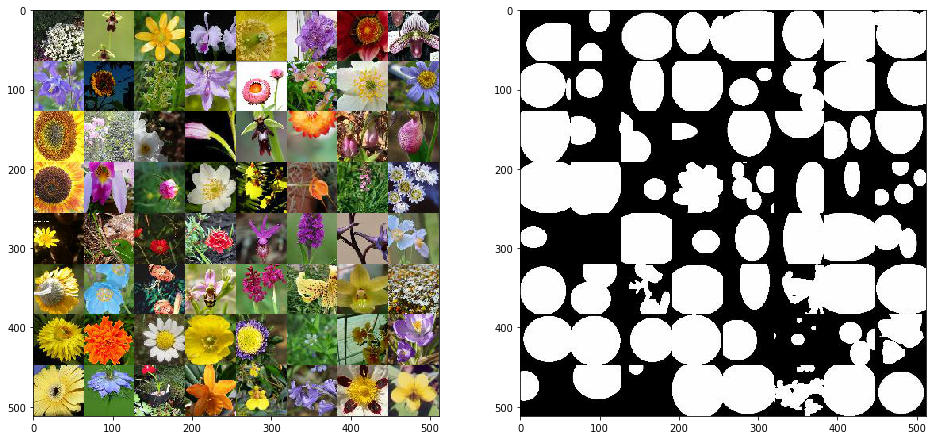

In [5]:
# Plot some training images
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
batch = next(iter(train_loader))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Training Images")
plt.subplot(1,2,1)
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:64], padding=0, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.imshow(np.transpose(vutils.make_grid(batch[1].to(device)[:64], padding=0, normalize=True).cpu(),(1,2,0)))

In [6]:
def train(train_loader, val_loader=None, model=None, epoch=1, optimizer=None, criterion=None, early_stopping=3, device=device):
        
    best_loss = 10000000
    best_epoch = 0
    best_model_wts = None
    
    for t in range(epoch):
        
        model.train()
        
        for i_batch, batch in tqdm(enumerate(train_loader)):
            
            batch_X, batch_y = batch[0].to(device), batch[1].to(device)
            batch_y_pred = model(batch_X)
            loss = criterion(batch_y_pred.view(-1), batch_y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if val_loader is not None: #evaluate on validation data
            
            model.eval()
            running_loss = 0.0
            with torch.no_grad():
                for i_batch, batch in enumerate(val_loader):
                    batch_X, batch_y = batch[0].to(device), batch[1].to(device)
                    batch_y_pred = model(batch_X)
                    loss = criterion(batch_y_pred.view(-1), batch_y.view(-1))                   
                    running_loss += loss.item() * batch_X.size()[0]
        
            epoch_loss = running_loss / len(val_loader.dataset)
            print ("epoch %d, loss %.6f"%(t, epoch_loss))
            
            if epoch_loss < best_loss: #keep track of best loss and epoch
                best_loss = epoch_loss
                best_epoch = t
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if (t - best_epoch > early_stopping): #early stopping if loss haven't improve for n=early_stopping rounds
                break
                
    if best_model_wts is not None:
        print("load best weights from epoch %d"%best_epoch)
        model.load_state_dict(best_model_wts)
        
        
def predict(predictions, dataloader, model):
    
    N = len(dataloader.dataset)
    n_batches = len(dataloader)
    batch_size = dataloader.batch_size
    
    model.eval()
    with torch.no_grad():
        for i_batch, batch in tqdm(enumerate(dataloader)):
            batch_X, batch_y = batch[0].to(device), batch[1].to(device)
            batch_y_pred = model(batch_X)
                
            start = i_batch * batch_size
            end = start + batch_size
            if i_batch == n_batches - 1:
                end = N
            predictions[start:end] = batch_y_pred   
                
    return predictions

In [7]:
net = UNet(n_channels=3, n_classes=1).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    net = nn.DataParallel(net, list(range(ngpu)))

optimizer = optim.SGD(net.parameters(),
                      lr=0.001,
                      momentum=0.9,
                      weight_decay=0.0005)

criterion = nn.BCELoss()
train(train_loader, val_loader, model=net, epoch=20, optimizer=optimizer, criterion=criterion, early_stopping=3)

!mkdir model_checkpoints
torch.save({
            'model_dict': net.state_dict(),
            'optimizer_dict': optimizer.state_dict()
            }, "model_checkpoints/unet")

0it [00:00, ?it/s]/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
215it [00:27,  7.88it/s]


epoch 0, loss 0.512709


215it [00:27,  7.90it/s]


epoch 1, loss 0.450896


215it [00:27,  7.89it/s]


epoch 2, loss 0.420048


215it [00:27,  7.90it/s]


epoch 3, loss 0.412976


215it [00:27,  7.89it/s]


epoch 4, loss 0.399427


215it [00:27,  7.92it/s]


epoch 5, loss 0.391367


215it [00:27,  7.90it/s]


epoch 6, loss 0.384122


215it [00:27,  7.90it/s]


epoch 7, loss 0.401277


215it [00:27,  7.90it/s]


epoch 8, loss 0.393678


215it [00:27,  7.90it/s]


epoch 9, loss 0.377129


215it [00:27,  7.90it/s]


epoch 10, loss 0.384206


215it [00:27,  7.90it/s]


epoch 11, loss 0.378248


215it [00:27,  7.89it/s]


epoch 12, loss 0.375925


215it [00:27,  7.90it/s]


epoch 13, loss 0.377106


215it [00:27,  7.90it/s]


epoch 14, loss 0.378862


215it [00:27,  7.90it/s]


epoch 15, loss 0.374283


215it [00:27,  7.90it/s]


epoch 16, loss 0.382520


215it [00:27,  7.90it/s]


epoch 17, loss 0.385977


215it [00:27,  7.90it/s]


epoch 18, loss 0.417051


215it [00:27,  7.90it/s]


epoch 19, loss 0.375484
load best weights from epoch 15
mkdir: cannot create directory ‘model_checkpoints’: File exists


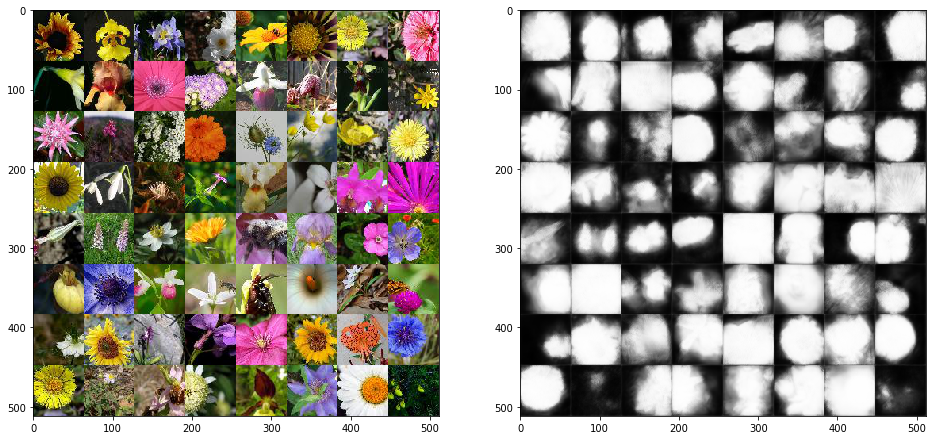

In [8]:
batch = next(iter(val_loader))
pred_masks = net(batch[0].to(device)).detach()
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("test on validation")
plt.subplot(1,2,1)
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:64], padding=0, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.imshow(np.transpose(vutils.make_grid(pred_masks.to(device)[:64], padding=0, normalize=True).cpu(),(1,2,0)))